# Predicting Customer Lifetime Value - Watson Analytics

### Packages

In [49]:
import numpy as np
from scipy.stats import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from datetime import datetime
from scipy.stats import wilcoxon
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Importing Data

In [2]:
# Set figure parameters
plt.rcParams['figure.figsize'] = [7, 5]
# Import Data
filename = 'watson_analytics.csv'
df = pd.read_csv(filename)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Identify Significant Categorical Variables

First, we must identify all the variables that might have significant differences within the subgroups of the category. Because there are 15 categorical variables, we write one piece of code to look at all the categories together. To do this, we create barplots for each variable to see if there are changes in the heights of the bars within each catagory. Then we will run more tests to observe whether the visual difference is statistically significant.

<Figure size 504x360 with 0 Axes>

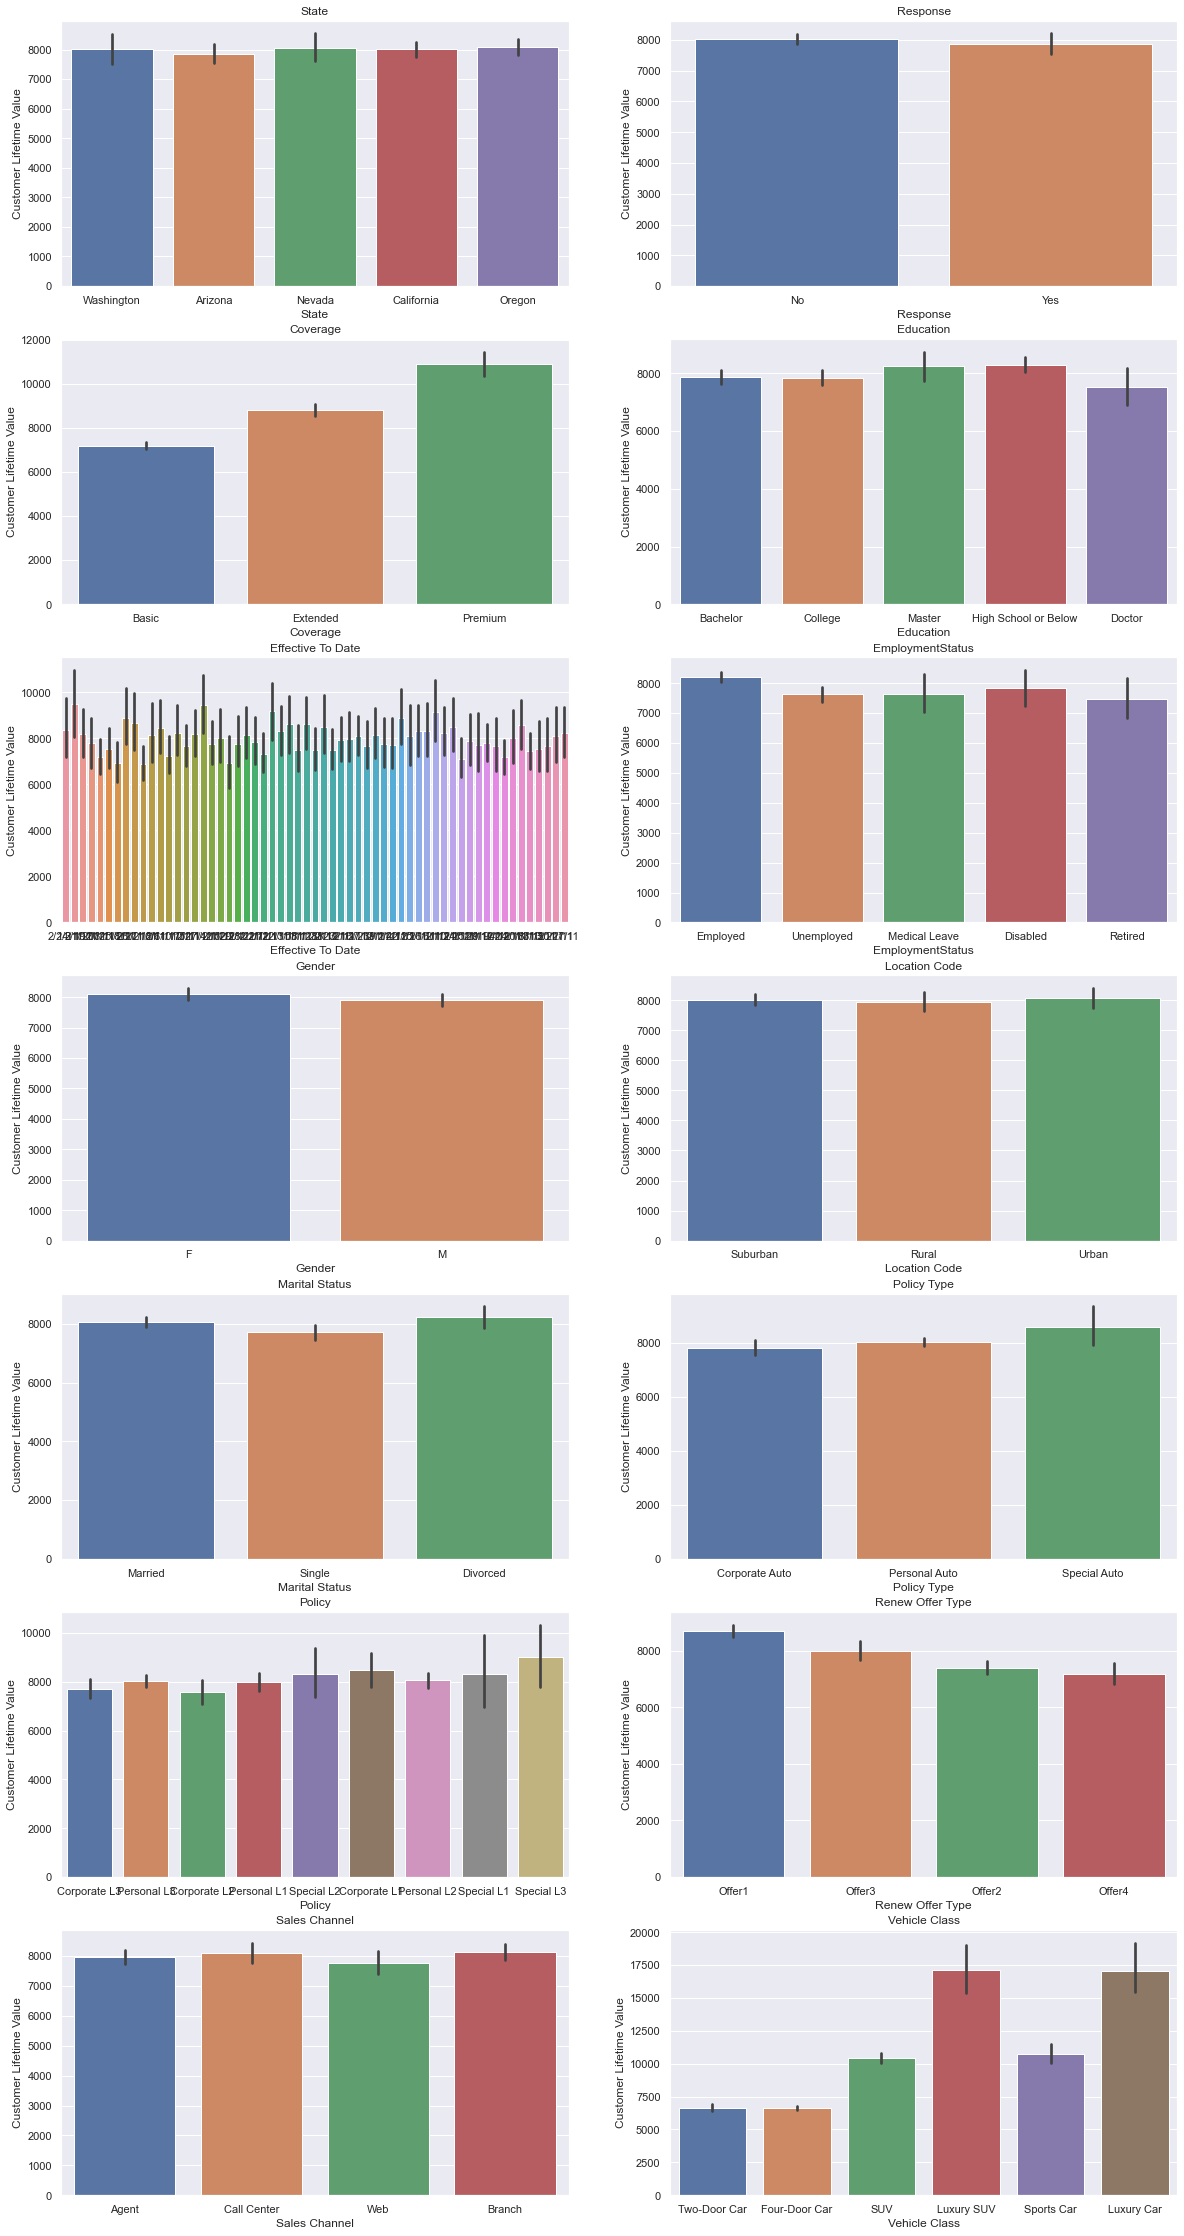

In [3]:
# Get all columns that are categorical
cat_df = df.select_dtypes(include='object')
cat_df = cat_df.drop(['Customer'], axis = 1)
cols = cat_df.columns

# Create a subplot for each category
sns.set(color_codes=True)
plt.subplots_adjust(hspace=0.5)
plt.figure(figsize=(20,40))

for i in range(len(cols) - 1):
    plt.subplot(7,2,i+1)
    sns.barplot(x = cols[i],y='Customer Lifetime Value',data = df)
    plt.title(cols[i])
    
plt.show()

Text(0.5, 1.0, 'Vehicle Size')

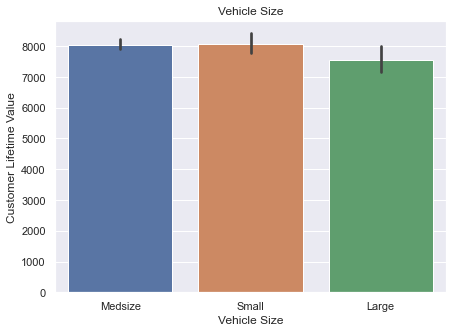

In [4]:
sns.barplot(x = 'Vehicle Size',y='Customer Lifetime Value',data = df)
plt.title('Vehicle Size')

From the barplots, there are significant differences in the sub-groups of the following variables:

* Coverage
* Education
* Employement Status
* Gender
* Marital Status
* Policy Type
* Policy
* Renew Offer Type
* Vehicle Class
* Vehicle Size

We will perform a t-test for Gender since there are only two sub-groups being compared, Male and Female. Then for the other categories, we will conduct a one-way ANOVA test.

### Gender

In [5]:
gender = df[['Customer Lifetime Value','Gender']].groupby('Gender')
female = gender['Customer Lifetime Value'].get_group('F')
male = gender['Customer Lifetime Value'].get_group('M')
stats.ttest_ind(female,male)

Ttest_indResult(statistic=1.300686352501256, pvalue=0.19339865630769232)

Since the p-value < 0.05, then we fail to reject the null hypothesis that there is no statistical significant difference between the mean Customer Lifetime Value of Males and Females. Therefore, Gender will not be included in our predictive models.

### Coverage

In [6]:
coverage = df[['Customer Lifetime Value','Coverage']].groupby('Coverage')
basic = coverage['Customer Lifetime Value'].get_group('Basic')
extended = coverage['Customer Lifetime Value'].get_group('Extended')
premium = coverage['Customer Lifetime Value'].get_group('Premium')
stats.f_oneway(basic,extended,premium)

F_onewayResult(statistic=133.67511419504908, pvalue=6.0158970099807e-58)

The One-Way ANOVA test produces an extremely small p-value, which means that there is a significant difference in the mean CLV for customers with different coverages. We will also look at the distribution of the data to determine whether or not the distributions and median differ between groups as well.

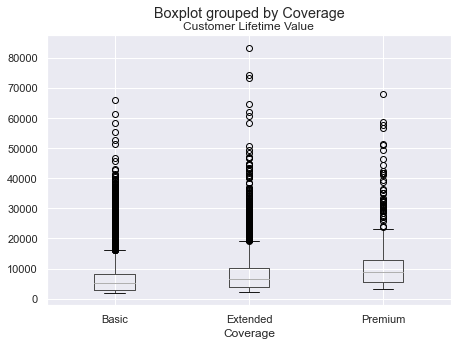

In [7]:
df.boxplot('Customer Lifetime Value', 'Coverage')

Since the median and quartile values increase as the coverage goes from Basic to Premium, this provides more evidence to Coverage being included in the model as changes in coverage are correlated with changes in CLV. 

### Education

In [8]:
education = df[['Customer Lifetime Value','Education']].groupby('Education')
bachelor = education['Customer Lifetime Value'].get_group('Bachelor')
college = education['Customer Lifetime Value'].get_group('College')
master = education['Customer Lifetime Value'].get_group('Master')
high_school = education['Customer Lifetime Value'].get_group('High School or Below')
doctor = education['Customer Lifetime Value'].get_group('Doctor')
stats.f_oneway(bachelor,college,master,high_school,doctor)

F_onewayResult(statistic=2.422865348052191, pvalue=0.04603615409468821)

The test produces an extremely p-value < 0.05, which means that there is a significant difference in the mean CLV for customers with different coverages. We will also look at the distribution of the data through boxplots.

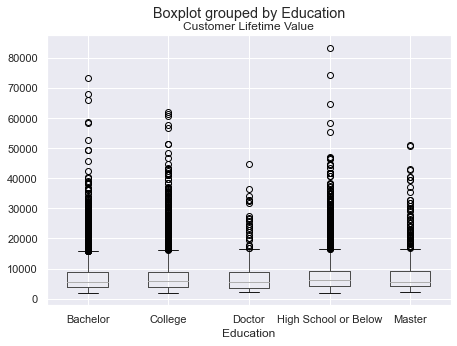

In [9]:
df.boxplot('Customer Lifetime Value', 'Education')

We can see from the boxplots that there is a difference in the medians for each education level, which supports the proposal to include 'Education' in the model.

### Employment Status

In [10]:
employment = df[['Customer Lifetime Value','EmploymentStatus']].groupby('EmploymentStatus')
employed = employment['Customer Lifetime Value'].get_group('Employed')
unemployed = employment['Customer Lifetime Value'].get_group('Unemployed')
medical = employment['Customer Lifetime Value'].get_group('Medical Leave')
disabled = employment['Customer Lifetime Value'].get_group('Disabled')
retired = employment['Customer Lifetime Value'].get_group('Retired')
stats.f_oneway(employed, unemployed, medical, disabled, retired)

F_onewayResult(statistic=3.809808710328605, pvalue=0.00425058662383102)

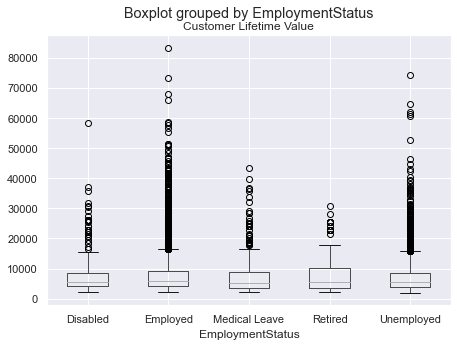

In [11]:
df.boxplot('Customer Lifetime Value', 'EmploymentStatus')

The test produces an extremely p-value < 0.05, which means that there is a significant difference in the mean CLV for customers with different employment statuses. The boxplots also show that the distributions are not the same across each level of employment. Both show that Education Status should be included in the model as it is strongly correlated with CLV.

###  Marital Status

In [12]:
marital = df[['Customer Lifetime Value','Marital Status']].groupby('Marital Status')
single = marital['Customer Lifetime Value'].get_group('Single')
married = marital['Customer Lifetime Value'].get_group('Married')
divorce = marital['Customer Lifetime Value'].get_group('Divorced')
stats.f_oneway(single, married, divorce)

F_onewayResult(statistic=3.3176649375891385, pvalue=0.036281036735873)

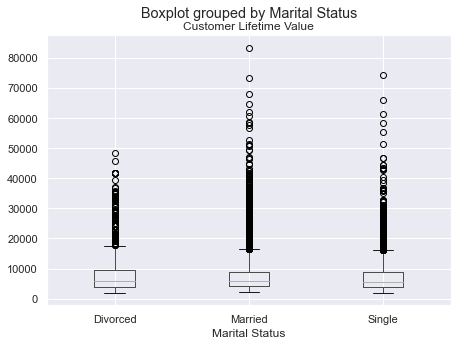

In [13]:
df.boxplot('Customer Lifetime Value', 'Marital Status')

The test produces an extremely p-value < 0.05, which means that there is a significant difference in the mean CLV for customers with different marital statuses. The boxplots also show that the distributions are not the same as the distribution for divorced people is less skewed than married and single people. Both show that Marital Status should be included in the model as it is strongly correlated with CLV.

### Policy Type

In [14]:
policy_type = df[['Customer Lifetime Value','Policy Type']].groupby('Policy Type')
corporate = policy_type['Customer Lifetime Value'].get_group('Corporate Auto')
special = policy_type['Customer Lifetime Value'].get_group('Special Auto')
personal = policy_type['Customer Lifetime Value'].get_group('Personal Auto')
stats.f_oneway(corporate, special, personal)

F_onewayResult(statistic=2.183644634048655, pvalue=0.11268909882175004)

Since the p-value > 0.05, we fail to reject the null hypothesis that there is no statistical difference between the sub-groups of Policy Type. Therefore, we do not include Policy Type in the model.

### Policy

In [15]:
policy = df[['Customer Lifetime Value','Policy']].groupby('Policy')
cl3 = policy['Customer Lifetime Value'].get_group('Corporate L3')
pl3 = policy['Customer Lifetime Value'].get_group('Personal L3')
sl3 = policy['Customer Lifetime Value'].get_group('Special L3')
cl2 = policy['Customer Lifetime Value'].get_group('Corporate L2')
pl2 = policy['Customer Lifetime Value'].get_group('Personal L2')
sl2 = policy['Customer Lifetime Value'].get_group('Special L2')
cl1 = policy['Customer Lifetime Value'].get_group('Corporate L1')
pl1 = policy['Customer Lifetime Value'].get_group('Personal L1')
sl1 = policy['Customer Lifetime Value'].get_group('Special L1')
stats.f_oneway(cl3,pl3,sl3,cl2,pl2,sl2,cl1,pl1,sl1)

F_onewayResult(statistic=1.1839990669675131, pvalue=0.3041951364145143)

Since the p-value > 0.05, we fail to reject the null hypothesis that there is no statistical difference between the sub-groups of Policy. Therefore, we do not include Policy in the model.

### Renew Offer Type

In [16]:
renew = df[['Customer Lifetime Value','Renew Offer Type']].groupby('Renew Offer Type')
offer1 = renew['Customer Lifetime Value'].get_group('Offer1')
offer2 = renew['Customer Lifetime Value'].get_group('Offer2')
offer3 = renew['Customer Lifetime Value'].get_group('Offer3')
offer4 = renew['Customer Lifetime Value'].get_group('Offer4')
stats.f_oneway(offer1,offer2,offer3,offer4)

F_onewayResult(statistic=25.83261444494041, pvalue=1.238399930571374e-16)

The One-Way ANOVA test produces an extremely small p-value, which means that there is a significant difference in the mean CLV for customers with different renew offer types. We will also look at the distribution of the data to determine whether or not the distributions and median differ between groups as well.

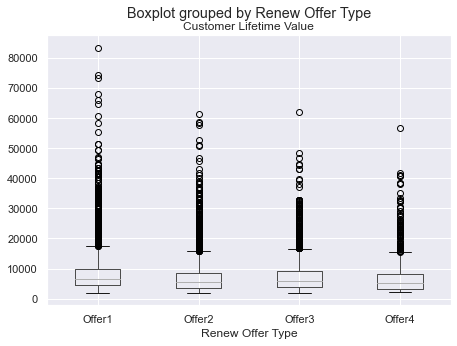

In [17]:
df.boxplot('Customer Lifetime Value', 'Renew Offer Type')

We can see that Offer 1 has a higher median CLV than the offers and Offer 3 has a higher median value that Offers 2 and 4. Therefore we must include Renew Offer Type as a categorical variable.

### Vehicle Class

From the barplots, it appears there is only a difference between cars in the following classes: Luxury, SUV or Sports, and Two-Door/Four-Door cars. Therefore, we only have to create three different sub-groups for this variable.

In [18]:
vehicle_class = df[['Customer Lifetime Value','Vehicle Class']].groupby('Vehicle Class')
luxury = pd.concat([vehicle_class['Customer Lifetime Value'].get_group('Luxury SUV'), 
           vehicle_class['Customer Lifetime Value'].get_group('Luxury Car')], axis = 0)
door = pd.concat([vehicle_class['Customer Lifetime Value'].get_group('Two-Door Car'), 
           vehicle_class['Customer Lifetime Value'].get_group('Four-Door Car')], axis = 0)
other = pd.concat([vehicle_class['Customer Lifetime Value'].get_group('SUV'), 
           vehicle_class['Customer Lifetime Value'].get_group('Sports Car')], axis = 0)
stats.f_oneway(luxury, door, other)

F_onewayResult(statistic=667.578688085395, pvalue=2.5571417337507106e-271)

The One-Way ANOVA test produces an extremely small p-value, which means that there is a significant difference in the mean CLV for customers with different vehicle classes. Hence, the three types of vehicle classes will be included in the model.

### Vehicle Size

In [19]:
v_size = df[['Customer Lifetime Value','Vehicle Size']].groupby('Vehicle Size')
small = v_size['Customer Lifetime Value'].get_group('Small')
medsize = v_size['Customer Lifetime Value'].get_group('Medsize')
large = v_size['Customer Lifetime Value'].get_group('Large')
stats.f_oneway(small, medsize, large)

F_onewayResult(statistic=2.382494601032998, pvalue=0.09237737701331775)

We will not include vehicle size in the model as the p-value is greater than 0.05.

Therefore, the categorical variables to be included in the model are
* Coverage
* Education
* Employement Status
* Marital Status
* Renew Offer Type
* Vehicle Class

We will create dummy variables for the sub-categories in each variable to be used in the model. A 1 in the column indicates that this sub-category is true for the customer and a 0 indicates that it is not.

In [20]:
coverage = pd.get_dummies(df['Coverage'])
education = pd.get_dummies(df['Education'])
employment = pd.get_dummies(df['EmploymentStatus'])
marital_status = pd.get_dummies(df['Marital Status'])
renew_offer_type = pd.get_dummies(df['Renew Offer Type'])
searchfor = ['SUV', 'Sports']
df['Luxury'] = np.where(df['Vehicle Class'].str.contains('Luxury'), 1, 0)
df['Two/Four-Door'] = np.where(df['Vehicle Class'].str.contains('Door'), 1, 0)
df['SUV/Sports Car'] = np.where(df['Vehicle Class'].str.contains('|'.join(searchfor)), 1, 0)

In [21]:
df = pd.concat([df, coverage, education, employment, marital_status, renew_offer_type], axis = 1)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Medical Leave,Retired,Unemployed,Divorced,Married,Single,Offer1,Offer2,Offer3,Offer4
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,0,0,0,0,1,0,1,0,0,0
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,0,0,1,0,0,1,0,0,1,0
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,0,0,0,0,1,0,1,0,0,0
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,0,0,1,0,1,0,1,0,0,0
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,0,0,0,0,0,1,1,0,0,0


## Identify Significant Numerical Variables

First, we look at Number of Policies and Number of Open Complaints as categorical variables because they are not continuous. We will plot bar plots similar to those above to see if any display significant differences in Customer Lifetime Value between the sub-groups.

### Number of Policies

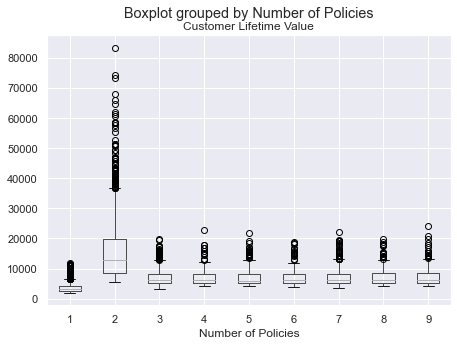

In [22]:
df.boxplot('Customer Lifetime Value', 'Number of Policies')

From the boxplots, it appears that CLV changes if a person has one policy, two policies, and three or more policies. We can use a One-Way ANOVA test to observe if this difference is statistically significant.

In [23]:
num_policies = df[['Customer Lifetime Value','Number of Policies']].groupby('Number of Policies')
one_policy = num_policies['Customer Lifetime Value'].get_group(1)
two_policy = num_policies['Customer Lifetime Value'].get_group(2)
three_more_policy = pd.concat([num_policies['Customer Lifetime Value'].get_group(3), 
                               num_policies['Customer Lifetime Value'].get_group(4),
                               num_policies['Customer Lifetime Value'].get_group(5), 
                               num_policies['Customer Lifetime Value'].get_group(6), 
                               num_policies['Customer Lifetime Value'].get_group(7), 
                               num_policies['Customer Lifetime Value'].get_group(8), 
                               num_policies['Customer Lifetime Value'].get_group(9)], axis = 0)
stats.f_oneway(one_policy, two_policy, three_more_policy)

F_onewayResult(statistic=4053.309978788064, pvalue=0.0)

With an extremely small p-value, we need to include dummy variables for these three groups of Number of Policies.

In [24]:
df['One Policy'] = np.where(df['Number of Policies'] == 1, 1, 0)
df['Two Policies'] = np.where(df['Number of Policies'] == 2, 1, 0)
df['3 or More Policies'] = np.where(df['Number of Policies'] >= 3, 1, 0)

### Number of Complaints

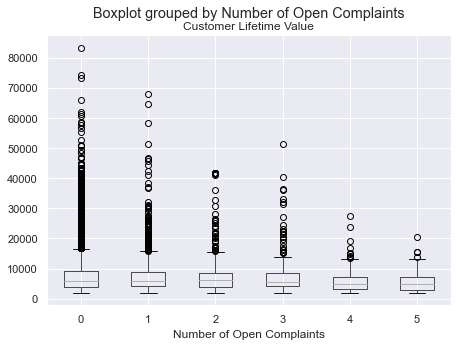

In [25]:
df.boxplot('Customer Lifetime Value', 'Number of Open Complaints')

The distributions look significantly as the skew in the distribution decreases as the number of policies increases. Therefore, we run another One-Way ANOVA test in order to test whether this difference is significant.

In [26]:
complaints = df[['Customer Lifetime Value','Number of Open Complaints']].groupby('Number of Open Complaints')
zero = complaints['Customer Lifetime Value'].get_group(0)
one = complaints['Customer Lifetime Value'].get_group(1)
two = complaints['Customer Lifetime Value'].get_group(2)
three = complaints['Customer Lifetime Value'].get_group(3)
four = complaints['Customer Lifetime Value'].get_group(4)
five = complaints['Customer Lifetime Value'].get_group(5)
stats.f_oneway(zero,one,two,three,four,five)

F_onewayResult(statistic=4.436417365088408, pvalue=0.0004884204153965216)

Due to the small p-value, we add Number of Complaints to the list of predictor variables to be included in the model.

In [27]:
complaints = pd.get_dummies(df['Number of Open Complaints'])
df = pd.concat([df, complaints], axis = 1)

Now, we will look at the continuous variables Income and Total Claim Amount to see if there is any relationship between these predictors and CLV.

### Income

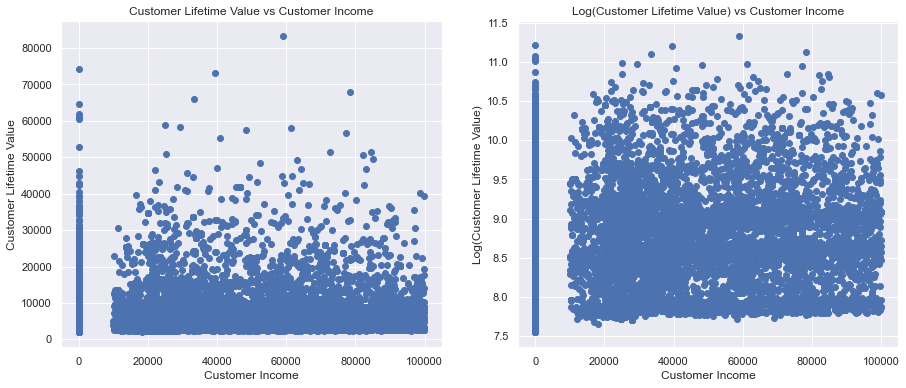

In [28]:
plt.figure(1, figsize=(15,6))
plt.subplot(1, 2, 1)
plt.scatter(df['Income'].to_numpy(), df['Customer Lifetime Value'].to_numpy())
plt.xlabel("Customer Income")
plt.ylabel("Customer Lifetime Value")
plt.title("Customer Lifetime Value vs Customer Income")

plt.subplot(1, 2, 2)
plt.scatter(df['Income'].to_numpy(), np.log(df['Customer Lifetime Value'].to_numpy()))
plt.xlabel("Customer Income")
plt.ylabel("Log(Customer Lifetime Value)")
plt.title("Log(Customer Lifetime Value) vs Customer Income")

plt.show()

In [29]:
np.corrcoef(df['Income'].to_numpy(), df['Customer Lifetime Value'].to_numpy())[0,1]

0.024365660747409076

In [30]:
np.corrcoef(df['Income'].to_numpy(), np.log(df['Customer Lifetime Value'].to_numpy()))[0,1]

0.04194985437535766

There appears to be no relationship between Income and Customer Lifetime Value. However, we can see a slight positive linear relationship with the Income and the log of CLV. Therefore, we should consider taking the log of the response variable as one of the predictive models.

### Total Claim Amount

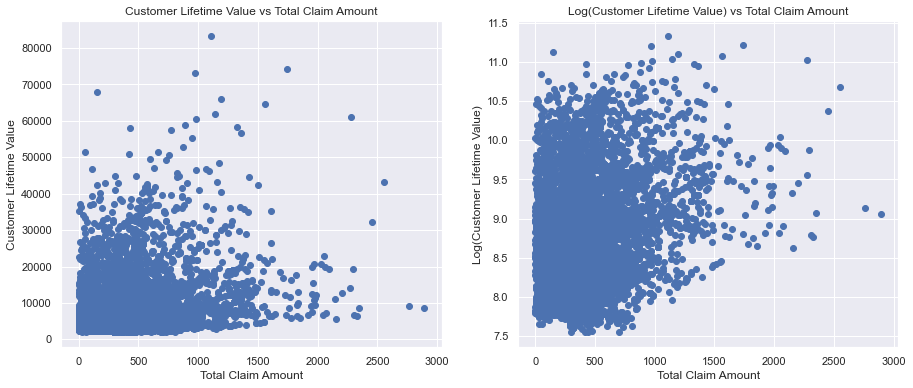

In [31]:
plt.figure(1, figsize=(15,6))
plt.subplot(1, 2, 1)
plt.scatter(df['Total Claim Amount'].to_numpy(), df['Customer Lifetime Value'].to_numpy())
plt.xlabel("Total Claim Amount")
plt.ylabel("Customer Lifetime Value")
plt.title("Customer Lifetime Value vs Total Claim Amount")

plt.subplot(1, 2, 2)
plt.scatter(df['Total Claim Amount'].to_numpy(), np.log(df['Customer Lifetime Value'].to_numpy()))
plt.xlabel("Total Claim Amount")
plt.ylabel("Log(Customer Lifetime Value)")
plt.title("Log(Customer Lifetime Value) vs Total Claim Amount")

plt.show()

In [32]:
np.corrcoef(df['Total Claim Amount'].to_numpy(), df['Customer Lifetime Value'].to_numpy())[0,1]

0.2264509152864171

In [33]:
np.corrcoef(df['Total Claim Amount'].to_numpy(), np.log(df['Customer Lifetime Value'].to_numpy()))[0,1]

0.24537449925491375

Similar to Income, there is a stronger linear relationship with Total Claim Amount and the log of Customer Lifetime Value than the response without the transformation. Therefore, it appears that taking the log of CLV will lead to a better predictive model.

Finally, we look at Monthly Premium Auto, Months Since Last Claim, Months Since Policy Inception by plotting them against Customer Lifetime Value to oberve any correlation.

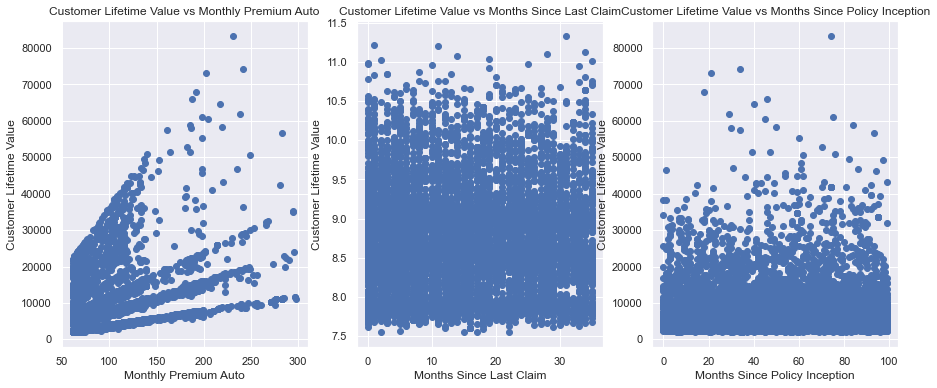

In [34]:
plt.figure(1, figsize=(15,6))
plt.subplot(1, 3, 1)
plt.scatter(df['Monthly Premium Auto'].to_numpy(), df['Customer Lifetime Value'].to_numpy())
plt.xlabel("Monthly Premium Auto")
plt.ylabel("Customer Lifetime Value")
plt.title("Customer Lifetime Value vs Monthly Premium Auto")

plt.subplot(1, 3, 2)
plt.scatter(df['Months Since Last Claim'].to_numpy(), np.log(df['Customer Lifetime Value'].to_numpy()))
plt.xlabel("Months Since Last Claim")
plt.ylabel("Customer Lifetime Value")
plt.title("Customer Lifetime Value vs Months Since Last Claim")

plt.subplot(1, 3, 3)
plt.scatter(df['Months Since Policy Inception'].to_numpy(), df['Customer Lifetime Value'].to_numpy())
plt.xlabel("Months Since Policy Inception")
plt.ylabel("Customer Lifetime Value")
plt.title("Customer Lifetime Value vs Months Since Policy Inception")

plt.show()

There appears to be no relationship between Months Since Last Claim and Months Since Policy Inception with Customer Lifetime Value. However, there is a positive linear relationship between Monthly Premuim Auto and CLV with a hidden varaible in correlation with Monthly Preimum Auto because the lines are split into groups. Hence, we will only include Monthly Preimum Auto in the model, but more in depth analysis is needed to remove possible auto-correlation within the predictors.

## Identify Possible Time Dependence

We will conduct a runs test with the mean and median of CLV that is grouped by 'Effective to Date' in order to identify whether there is a correlation with CLV to dates that are near each other. Large p-values indicate that there is no evidence of time dependence.

In [35]:
runstest_1samp(df.groupby(['Effective To Date'])['Customer Lifetime Value'].median(), correction=False)

(-1.5639734118331756, 0.11782381258601812)

In [36]:
runstest_1samp(df.groupby(['Effective To Date'])['Customer Lifetime Value'].mean(), correction=False)

(1.4472343999120243, 0.14783128501511286)

As both p-values are greater than 0.05, there is no significant evidence of time dependence in the data. Hence, 'Effective to Date' will not be included in the models.

## Models

### Multiple Linear Regression Model
First, we will use a MLR model with all the columns that we found to be correlated with Customer Lifetime value. Our measures of accuracy will be mean squared error, mean absolute percentage error (MAPE), r squared, and adjusted r squared. Additionally, we will plot the test set against the predictions to observe whether certain values are not being predicted well.

In [37]:
def linmodel_m(feature_cols):
    X = df[feature_cols].to_numpy() #defines the features
    Y = df['Customer Lifetime Value'].to_numpy() #labels (or what we are predicting)
    
    #create a testing dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

    lin = LinearRegression() #model that we use
    lin.fit(X_train,Y_train)
    
    Y_pred = lin.predict(X_test) #evaluation and prediction
    print("Mean Sq. Error (MSE) : {}".format(mse(Y_test, Y_pred)))
    print("Mean Abs. Perc. Error (MAPE) : {}".format(np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100))
    print('R_squared:', r2_score(Y_test, Y_pred))
    print('Adjusted R_squared:', 1-(1-r2_score(Y_test, Y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))
    
    sns.set(color_codes=True)
    plt.scatter(Y_test, Y_pred)
    plt.plot(Y_test, Y_test, color="red")
    plt.xlabel("Actual CLV")
    plt.ylabel("Estimated CLV", )
    plt.title("Actual vs Estimated CLV")
    plt.show()

In [38]:
df = df.loc[:,~df.columns.duplicated()]

Mean Sq. Error (MSE) : 16490422.347683905
Mean Abs. Perc. Error (MAPE) : 24.827571151189947
R_squared: 0.6331285708385361
Adjusted R_squared: 0.6274153338994255


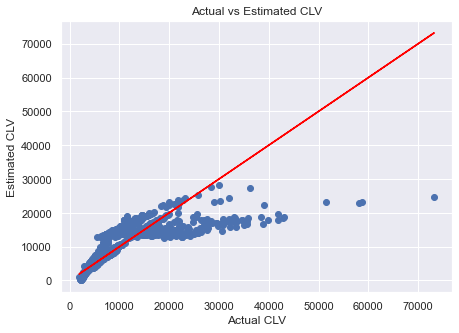

In [39]:
linmodel_m(['Bachelor','College','Doctor','High School or Below','Master','One Policy',
           'Two Policies','3 or More Policies','Offer1','Offer2','Offer3','Offer4',
           'Employed','Medical Leave','Retired','Unemployed','Divorced','Married',
           'Single','Luxury','Two/Four-Door','SUV/Sports Car','Basic','Extended','Premium',
           'Monthly Premium Auto', 'Total Claim Amount', 'Income'])

From the output, there is an extremely high MSE and the R squared values show that the data does not fit to the MLR model very well. There appears to be a logarithmic curve to the data, so we will fit the same columns as the predictors with the log(Customer Lifetime Value) in the next model. 

### MLR with log(Customer Lifetime Value)
We will use the same code as above with the small change in that $Y$ will now be $log(Y)$ as the response variable

In [40]:
def linmodel_log_m(feature_cols):
    X = df[feature_cols].to_numpy() #defines the features
    Y = np.log(df['Customer Lifetime Value'].to_numpy()) #labels (or what we are predicting)
    
    #create a testing dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

    lin = LinearRegression() #model that we use
    lin.fit(X_train,Y_train)
    
    Y_pred = lin.predict(X_test) #evaluation and prediction
    print("Mean Sq. Error (MSE) : {}".format(mse(Y_test, Y_pred)))
    print("Mean Abs. Perc. Error (MAPE) : {}".format(np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100))
    print('R_squared:', r2_score(Y_test, Y_pred))
    print('Adjusted R_squared:', 1-(1-r2_score(Y_test, Y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))
    
    sns.set(color_codes=True)
    plt.scatter(Y_test, Y_pred)
    plt.plot(Y_test, Y_test, color="red")
    plt.xlabel("Actual CLV")
    plt.ylabel("Estimated CLV", )
    plt.title("Actual vs Estimated CLV")
    plt.show()

Mean Sq. Error (MSE) : 0.04381414880349034
Mean Abs. Perc. Error (MAPE) : 1.3033214103974042
R_squared: 0.8957767433706327
Adjusted R_squared: 0.8941536893185625


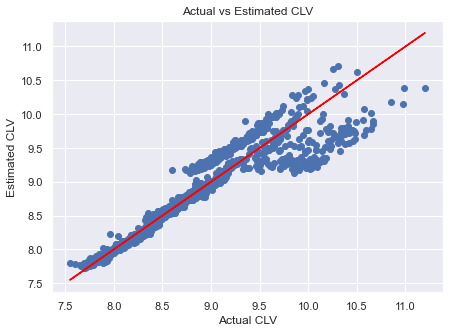

In [41]:
linmodel_log_m(['Bachelor','College','Doctor','High School or Below','Master','One Policy',
           'Two Policies','3 or More Policies','Offer1','Offer2','Offer3','Offer4',
           'Employed','Medical Leave','Retired','Unemployed','Divorced','Married',
           'Single','Luxury','Two/Four-Door','SUV/Sports Car','Basic','Extended','Premium',
           'Monthly Premium Auto', 'Total Claim Amount', 'Income'])

We see a significant improvement in the predictions from the MLR without the transformation of Customer Lifetime Value. The MSE is very small and the high R squared shows the data fits the model well. Despite, this there appears to be a slight curvature in the data, so we will also use a polynomial model to account for possible nonllinearity in the data.

### Polynomial Model (degree 2) with log (Customer Lifetime Value)
We will fit a polynomial model of degree 2 first to see if there is an improvement in the MSE and R squared values. If there is, then we will also test a model with degree 3.

In [42]:
def polymodel(feature_cols, degree=1):
    X = df[feature_cols].to_numpy() #defines the features
    Y = np.log(df['Customer Lifetime Value'].to_numpy()) #labels (or what we are predicting)
    
    pol = PolynomialFeatures(degree=degree)
    X = pol.fit_transform(X)

    #create a testing dataset

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

    lin = LinearRegression()
    lin.fit(X_train,Y_train)
    Y_pred = lin.predict(X_test)

    print("Mean Sq. Error (MSE) : {}".format(mse(Y_test, Y_pred)))
    print("Mean Abs. Perc. Error (MAPE) : {}".format(np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100))
    print('R_squared:', r2_score(Y_test, Y_pred))
    print('Adjusted R_squared:', 1-(1-r2_score(Y_test, Y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))
    print('MSE for CLV < 10000 : {}'.format(mse(Y_test[Y_test<10],Y_pred[Y_test<10])))
    
    sns.set(color_codes=True)
    plt.scatter(Y_test, Y_pred)
    plt.plot(Y_test, Y_test, color="red")
    plt.xlabel("Actual CLV")
    plt.ylabel("Estimated CLV", )
    plt.title("Actual vs Estimated CLV")
    plt.show()

Mean Sq. Error (MSE) : 0.04230612228352759
Mean Abs. Perc. Error (MAPE) : 1.2287058225200473
R_squared: 0.8993639735071555
Adjusted R_squared: 0.8678926064874665
MSE for CLV < 10000 : 0.024650946960055473


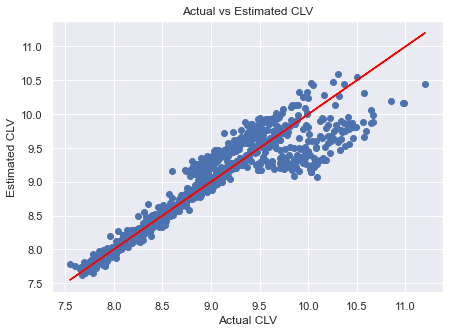

In [43]:
polymodel(['Bachelor','College','Doctor','High School or Below','Master','One Policy',
           'Two Policies','3 or More Policies','Offer1','Offer2','Offer3','Offer4',
           'Employed','Medical Leave','Retired','Unemployed','Divorced','Married',
           'Single','Luxury','Two/Four-Door','SUV/Sports Car','Basic','Extended','Premium',
           'Monthly Premium Auto', 'Total Claim Amount', 'Income'],2)

There does not seem to be much of an improvement when we include polynomial features, but it is slightly better than the MLR model. Therefore, it appears that a polynomial model of degree 2 is the best model to use when predicting Customer Lifetime Value. In both outputs of Actual vs Estimated CLV, we notice that there is an increase in variation among points where the CLV is greater than 10,000. We can calculate the MSE without these values to observe if there is a range where predictions are better than others.

When we add in the line of code ```mse(Y_test[Y_test<10],Y_pred[Y_test<10])``` to the polynomial model, we see that the MSE reduces in half, indicating that the model might be a better predictor for customers with a Customer Lifetime Value below 10000. Since the model accounts for 90/% of the variance in the data, it is a good fit. Now, we will look to see if there is a case of overfitting or underfitting from the model before we make a conclusion.

## Checking for Overfitting/Underfitting

In [47]:
def polymodel_check(feature_cols, degree=1):
    X = df[feature_cols].to_numpy() #defines the features
    Y = np.log(df['Customer Lifetime Value'].to_numpy()) #labels (or what we are predicting)
    
    pol = PolynomialFeatures(degree=degree)
    X = pol.fit_transform(X)

    #create a testing dataset

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

    lin = LinearRegression()
    lin.fit(X_train,Y_train)
    Y_pred = lin.predict(X_test)
    Y_pred_train = lin.predict(X_train)
    
    print("Train observation number  : {}".format(X_train.shape[0]))
    print("Test observation number   : {}".format(X_test.shape[0]), "\n")

    print("Train R-Square  : {}".format(r2_score(Y_train, Y_pred_train)))
    print("-----Test Scores---")
    print("Mean Sq. Error (MSE) : {}".format(mse(Y_test, Y_pred)))
    print("Mean Abs. Perc. Error (MAPE) : {}".format(np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100))
    print('R_squared:', r2_score(Y_test, Y_pred))
    print('Adjusted R_squared:', 1-(1-r2_score(Y_test, Y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))
    print('MSE for CLV < 10000 : {}'.format(mse(Y_test[Y_test<10],Y_pred[Y_test<10])))

In [48]:
polymodel_check(['Bachelor','College','Doctor','High School or Below','Master','One Policy',
           'Two Policies','3 or More Policies','Offer1','Offer2','Offer3','Offer4',
           'Employed','Medical Leave','Retired','Unemployed','Divorced','Married',
           'Single','Luxury','Two/Four-Door','SUV/Sports Car','Basic','Extended','Premium',
           'Monthly Premium Auto', 'Total Claim Amount', 'Income'],2)

Train observation number  : 7307
Test observation number   : 1827 

Train R-Square  : 0.9061915272138574
-----Test Scores---
Mean Sq. Error (MSE) : 0.04230612228352759
Mean Abs. Perc. Error (MAPE) : 1.2287058225200473
R_squared: 0.8993639735071555
Adjusted R_squared: 0.8678926064874665
MSE for CLV < 10000 : 0.024650946960055473


In [52]:
feature_cols = ['Bachelor','College','Doctor','High School or Below','Master','One Policy',
           'Two Policies','3 or More Policies','Offer1','Offer2','Offer3','Offer4',
           'Employed','Medical Leave','Retired','Unemployed','Divorced','Married',
           'Single','Luxury','Two/Four-Door','SUV/Sports Car','Basic','Extended','Premium',
           'Monthly Premium Auto', 'Total Claim Amount', 'Income']
X = df[feature_cols].to_numpy() #defines the features
Y = np.log(df['Customer Lifetime Value'].to_numpy()) #labels (or what we are predicting)
pol = PolynomialFeatures(2)
X = pol.fit_transform(X)
lin = LinearRegression()
cross_val_score(lin, X, Y, cv=10)

array([0.89710007, 0.89631958, 0.91173905, 0.89969783, 0.90840583,
       0.89002162, 0.901191  , 0.90029963, 0.89265752, 0.89590009])

We see that the estimator scores are the same for each run of the cross validation, which confirms that there is no overfitting or underfitting as none of the sets had a score of 1, which is perfect prediction.

## Conclusion

We can conclude that a polynomial model (polynomial transformation of features in a linear multiple regression model) is a good predictive model for predicting Customer Lifetime Value as the model accounts for around 90/% of the variation in the data. We can also improve this score by limiting the maximum CLV to 10000, which reduces the MSE by half. Therefore, we have a model that uses the provided features to better estimate the CLV of a new customer and be relatively close to their actual CLV. This is useful in marketing to customers with certain characteristics that are known to have higher CLV